***Laboratorio semana 3:  Análisis de ANOVA de una y dos vías***

A menudo, el análisis de algoritmos se basa en la **complejidad temporal**, utilizando la notación O(n3) para describir el tiempo de ejecución de la multiplicación de matrices. Sin embargo, esta visión puede ser incompleta, ya que no considera factores clave de la arquitectura de computadores como la **jerarquía de memoria**.

En la práctica, se experimentará que las variaciones en el rendimiento de diferentes versiones de los algoritmos que no están reflejadas en la complejidad teórica. Este laboratorio permitirá evidenciar que, aunque 6 algoritmos tengan la misma complejidad O(n3) su tiempo real de ejecución puede diferir significativamente.

El análisis de **ANOVA de una vía** permitirá determinar si existen diferencias significativas en el tiempo de ejecución entre las distintas versiones del algoritmo.

Posteriormente, con **ANOVA de dos vías**, se incorporará un segundo factor: el tamaño de la matriz, ajustado para ocupar distintos niveles de la jerarquía de memoria (L1, L2, L3 y RAM).  Esto facilitará la evaluación tanto de los efectos individuales de cada factor como de su interacción.

Además, se realizará un **análisis exploratorio de datos**, empleando gráficos de cajas y bigotes para identificar valores atípicos y comparaciones post-hoc en caso de que el ANOVA indique diferencias significativas.
Además, se generará una **matriz de aleatorización** para controlar sesgos en la ejecución de los experimentos y garantizar la validez de las conclusiones.


**Objetivos:**

Determinar si existen diferencias significativas en el tiempo de ejecución normalizado entre versiones del algoritmo.

Aplicar ANOVA de una vía para analizar el impacto del factor versión del algoritmo.

Aplicar ANOVA de dos vías considerando además el tamaño de la matriz como un segundo factor.

Utilizar herramientas gráficas como diagramas de cajas y bigotes para visualizar la distribución de los tiempos de ejecución y detectar valores atípicos.




In [1]:
# Instalación de librerías
!pip install researchpy
# Importar librerías
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import researchpy as rp
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from scipy.stats import f_oneway
import numpy as np
import random

# Gráfico de Cajas y Bigotes
def boxplot_version(df_data):
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='version', y='Normalized_ns', data=df_data)
    plt.xlabel('Versión del Algoritmo')
    plt.ylabel('Tiempo Normalizado (ns)')
    plt.title('Distribución de Tiempos de Ejecución')
    plt.show()

#boxplot_version(df)

#  Detección de Valores Atípicos
def detectar_outliers(data, umbral=3):
    media = np.mean(data)
    desviacion = np.std(data)
    outliers = [x for x in data if abs(x - media) > umbral * desviacion]
    return outliers

def boxplot_version(df_data):
  # Crear el gráfico de cajas y bigotes
  print("===========          Gráfico de cajas y bigotes         ================")
  # Suponiendo que 'Normalized (ns)' es la columna que contiene los datos de tiempo normalizado y 'version' es la columna que indica la versión del algoritmo
  sns.set(style="whitegrid")  # Establecer el estilo del gráfico
  plt.figure(figsize=(10, 6))  # Tamaño del gráfico
  sns.boxplot(x='version', y='Normalized_ns', data=df_data)
    # Etiquetas y título
  plt.xlabel('Algoritmo')
  plt.ylabel('Tiempo normalizado(ns)')
  plt.title('Gráfico de Cajas y Bigotes para Tiempos de Ejecución')
  # Mostrar el gráfico
  plt.show()

def detectar_outliers_desviacion_estandar(data, umbral=3):
    media = np.mean(data)
    desviacion_estandar = np.std(data)
    outliers = [x for x in data if abs(x - media) > umbral * desviacion_estandar]
    return outliers


**Cargar datos de la Semana 2**

Importe los datos recolectados en la semana 2 y guardelos en un dataframe, seleecione la hoja con nombre 'data', es decir los datos con las 12 muestras de cada uno de los 6 nivels del factor versión.


In [2]:
# Cargar datos de la Semana 2

df = pd.read_excel("tr5.xlsx", "")
df = df.rename(columns={"Normalized(ns)": "Normalized_ns", "ver": "version"})
df['version'] = df['version'].str.strip()
df.info()
print(df.head())

ValueError: Worksheet named 'data' not found

Cerciórese que se importaron 72 filas y 7 columnas, y que haya exactamente 6 niveles del factor de estudio versión (N=90 datos)

In [ ]:
#Verificar el número de niveles del factor Version
print(df['version'].unique())
print(rp.summary_cont(df['Normalized_ns']))
print("   ")
print("================= Resumen de Estadísticas por Versión=============")
print(rp.summary_cont(df['Normalized_ns'].groupby(df['version'])))
print("   ")


['C++ver(a)' 'C++ver(b)' 'C++ver(c)' 'C++ver(d)' 'C++ver(e)' 'C++ver(f)']


        Variable     N    Mean      SD      SE  95% Conf.  Interval
0  Normalized_ns  72.0  5.9826  4.3628  0.5142     4.9574    7.0078
   
================= Resumen de Estadísticas por Versión=============


            N     Mean      SD      SE  95% Conf.  Interval
version                                                    
C++ver(a)  12   2.9840  0.1212  0.0350     2.9070    3.0610
C++ver(b)  12   3.0466  0.2066  0.0596     2.9153    3.1779
C++ver(c)  12   2.8896  0.1293  0.0373     2.8075    2.9717
C++ver(d)  12   2.7668  0.0099  0.0029     2.7606    2.7731
C++ver(e)  12  12.1382  0.0915  0.0264    12.0801   12.1964
C++ver(f)  12  12.0705  0.2766  0.0798    11.8948   12.2462
   


/usr/local/lib/python3.11/dist-packages/researchpy/summary.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Normalized_ns' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  table.iloc[0,0] = group1.name


**Error relativo vs Tamaño de la muestra**

In [ ]:
Stat_data=df[["Normalized_ns", "version"]].groupby("version").agg({"Normalized_ns":["min", "max", "median", "mean" ,np.std,np.var]})
Stat_data=Stat_data.Normalized_ns
print(Stat_data)
Er=3 # 1%
Error_abs=Stat_data['mean']*(Er/100)
print("")
print("Cálculo del Error absoluto equivalente a Er=3%")
print(Error_abs)
print("")
print("Cálculo del Tamaño de Muestra ")
Z=1.96 #95%
print(Stat_data['var']*(Z*Z)/(Error_abs*Error_abs))
print("")


              min     max   median       mean       std       var
version                                                          
C++ver(a)   2.778   3.156   2.9975   2.984000  0.121218  0.014694
C++ver(b)   2.849   3.374   2.9725   3.046583  0.206626  0.042694
C++ver(c)   2.746   3.139   2.8500   2.889583  0.129262  0.016709
C++ver(d)   2.758   2.790   2.7625   2.766833  0.009880  0.000098
C++ver(e)  12.022  12.297  12.1325  12.138250  0.091493  0.008371
C++ver(f)  11.859  12.890  11.9955  12.070500  0.276576  0.076494

Cálculo del Error absoluto equivalente a Er=3%
version
C++ver(a)    0.089520
C++ver(b)    0.091398
C++ver(c)    0.086687
C++ver(d)    0.083005
C++ver(e)    0.364147
C++ver(f)    0.362115
Name: mean, dtype: float64

Cálculo del Tamaño de Muestra 
version
C++ver(a)     7.043794
C++ver(b)    19.634276
C++ver(c)     8.541615
C++ver(d)     0.054423
C++ver(e)     0.242511
C++ver(f)     2.241027
dtype: float64



<ipython-input-6-e3e6917e4853>:1: FutureWarning: The provided callable <function std at 0x79e790f4dc60> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  Stat_data=df[["Normalized_ns", "version"]].groupby("version").agg({"Normalized_ns":["min", "max", "median", "mean" ,np.std,np.var]})
<ipython-input-6-e3e6917e4853>:1: FutureWarning: The provided callable <function var at 0x79e790f4dda0> is currently using SeriesGroupBy.var. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "var" instead.
  Stat_data=df[["Normalized_ns", "version"]].groupby("version").agg({"Normalized_ns":["min", "max", "median", "mean" ,np.std,np.var]})


¿Cuándo es mejor utilizar la mediana en lugar de la media?

**P2.** A partir del cálculo del tamaño de muestra necesario para cada versión del algoritmo, se debe evaluar si el número de muestras recolectadas en el experimento es suficiente para garantizar una estimación precisa del tiempo de ejecución normalizado.

**¿El número de muestras definido es válido?**

-Se comparará el tamaño de muestra calculado con el número de observaciones del experimento inicial.

-Si el valor calculado es mayor al número de muestras recolectadas, se requeriría aumentar el número de repeticiones para reducir la incertidumbre en la estimación.
-Si el valor es menor, se considera que la cantidad de datos es suficiente para el análisis.




**Diagrama de cajas y bigotes**

===========          Gráfico de cajas y bigotes         ================


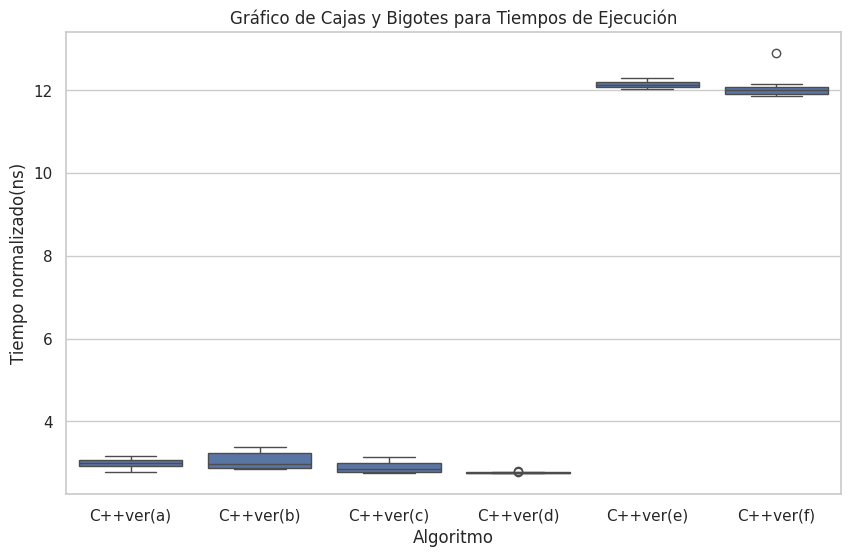

In [ ]:
# Crear el gráfico de cajas y bigotes
boxplot_version(df)


**P2** ¿Cuál versión del algoritmo tiene mayor y menor variabilidad?

**P4.** En qué tipo de algoritmo observa valores atípicos, que criterio se usa para considerar un dato como atípico?





**Análisis de Varianza de una vía**

El Análisis de Varianza de una vía (ANOVA de una vía) es una técnica estadística utilizada para comparar las medias de dos o más grupos y determinar si existen diferencias significativas entre ellas.

En este caso, se analizará si el tiempo de ejecución normalizado varía significativamente entre las diferentes versiones del algoritmo.

El ANOVA de una vía se basa en la descomposición de la variabilidad total de los datos en dos componentes principales:

**Variabilidad entre los grupos (Factor):** Diferencias debidas a la variación entre las versiones del algoritmo.

**Variabilidad dentro de los grupos (Error o Residual):** Diferencias debidas a la variabilidad natural dentro de cada versión.

La tabla ANOVA presenta los siguientes parámetros clave:

**-DF (Grados de Libertad):** Número de valores independientes en el análisis.

**-SC (Suma de Cuadrados):** Medida de la variabilidad total y su distribución entre el factor y el error.

**-MC (Media Cuadrática):** Promedio de la suma de cuadrados dividido por los grados de libertad.

**-F (Estadístico F):** Relación entre la variabilidad entre grupos y la variabilidad dentro de los grupos.

**-Valor p:** Indica la probabilidad de obtener los resultados observados si no hay diferencias reales entre los grupos.

Interpretación del ANOVA:

Si el **valor p** es menor que un umbral de significancia **(𝛼)**, se rechaza la hipótesis nula, lo que sugiere que al menos una versión del algoritmo tiene un tiempo de ejecución significativamente diferente.

Si el **valor p** es mayor que **𝛼**, no hay suficiente evidencia para concluir que existen diferencias entre las versiones analizadas.

Este análisis es fundamental para evaluar el impacto de diferentes implementaciones en el rendimiento computacional y guiar la elección del algoritmo más eficiente.



In [ ]:
# ANOVA de una vía
# Realizamos el análisis de un factor usando ANOVA
formula = 'Q("Normalized_ns") ~ C(version) '  # Indicamos que queremos evaluar el impacto de version
modelo1Factor = ols(formula, alpha=0.05, data=df).fit() # La fórmula 'Normalized_ns ~ C(version)' indica que se está evaluando el efecto de la variable 'version' sobre la variable 'Normalized_ns'.
anova_table = sm.stats.anova_lm(modelo1Factor, typ=2) #anova_lm() para calcular la tabla ANOVA a partir del modelo ajustado. El argumento typ=2 especifica que se debe utilizar el tipo 2 (El orden de las variables en el modelo no afecta el cálculo) de suma de cuadrados.
print("===========          TABLA ANOVA one way         ================")
print(anova_table)
print(" ")

print("Valor p para C(version):", anova_table.loc['C(version)', 'PR(>F)'])
print("alpha: 0.05")
print("")

===========          TABLA ANOVA one way         ================
                 sum_sq    df             F        PR(>F)
C(version)  1349.691078   5.0  10182.535858  7.561942e-94
Residual       1.749655  66.0           NaN           NaN
 
Valor p para C(version): 7.561942499439914e-94
alpha: 0.05



/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['alpha']
  warnings.warn(msg, ValueWarning)


**P4** ¿Cómo se interpreta el valor p obtenido en la tabla ANOVA con respecto a las hipótesis nula y alternativa planteadas sobre las diferencias en el tiempo de ejecución entre las versiones del algoritmo?



**Comparación por pares (post-hoc)**

Una vez realizado el ANOVA de una vía, si se encuentra una diferencia significativa en los tiempos de ejecución entre las versiones del algoritmo (p
< 0.05), el siguiente paso es identificar qué grupos de versiones presentan diferencias entre sí. Para ello, se utilizan pruebas post-hoc, que permiten realizar comparaciones múltiples entre pares de grupos sin aumentar el riesgo de errores estadísticos.

**P5.¿Sería útil realizar análisis adicionales, como comparaciones por pares (post-hoc), para identificar específicamente qué grupos de versiones del algoritmo presentan diferencias significativas en el tiempo de ejecución?**

Sí, si el ANOVA indica que existen diferencias significativas entre las versiones, se debe aplicar un análisis post-hoc para determinar cuáles versiones del algoritmo presentan esas diferencias. Esto es importante porque el ANOVA solo indica que existe al menos una diferencia, pero no señala específicamente entre qué versiones ocurre.

**P6.**¿Qué método de comparación post-hoc sería apropiado para este caso?

El método de comparación post-hoc más adecuado dependerá del contexto, pero algunos de los más utilizados incluyen:

**Prueba de Tukey HSD** (Honestly Significant Difference):
Apropiada cuando se comparan múltiples grupos de manera equitativa.

**Prueba de Bonferroni:** Útil para reducir el riesgo de errores tipo I en comparaciones múltiples.

**Prueba de Scheffé:** Más conservadora, adecuada para cualquier tipo de comparación entre grupos.

En este caso, dado que se comparan varias versiones del algoritmo, la prueba de **Tukey HSD** es la opción que vamos a usar (y es la prueba que probablemente usaron en inferencia estadística) , ya que permite evaluar todas las diferencias posibles entre los grupos con un control adecuado del error tipo I.




In [ ]:
# Prueba Post-hoc (Tukey HSD si ANOVA es significativo)
from statsmodels.stats.multicomp import pairwise_tukeyhsd

if anova_table.loc['C(version)', 'PR(>F)'] < 0.05:
    tukey = pairwise_tukeyhsd(df['Normalized_ns'], df['version'], alpha=0.05)
    print(tukey)

   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1    group2  meandiff p-adj   lower   upper  reject
----------------------------------------------------------
C++ver(a) C++ver(b)   0.0626 0.9341 -0.1325  0.2577  False
C++ver(a) C++ver(c)  -0.0944 0.7146 -0.2895  0.1007  False
C++ver(a) C++ver(d)  -0.2172 0.0205 -0.4123 -0.0221   True
C++ver(a) C++ver(e)   9.1543    0.0  8.9592  9.3493   True
C++ver(a) C++ver(f)   9.0865    0.0  8.8914  9.2816   True
C++ver(b) C++ver(c)   -0.157 0.1849 -0.3521  0.0381  False
C++ver(b) C++ver(d)  -0.2797 0.0011 -0.4748 -0.0847   True
C++ver(b) C++ver(e)   9.0917    0.0  8.8966  9.2868   True
C++ver(b) C++ver(f)   9.0239    0.0  8.8288   9.219   True
C++ver(c) C++ver(d)  -0.1227 0.4438 -0.3178  0.0723  False
C++ver(c) C++ver(e)   9.2487    0.0  9.0536  9.4438   True
C++ver(c) C++ver(f)   9.1809    0.0  8.9858   9.376   True
C++ver(d) C++ver(e)   9.3714    0.0  9.1763  9.5665   True
C++ver(d) C++ver(f)   9.3037    0.0  9.1086  9.4988   Tr

**Interpretación de los Resultados de la Prueba Tukey HSD**

Los resultados de la prueba de comparaciones múltiples de Tukey HSD permiten identificar qué versiones del algoritmo presentan diferencias estadísticamente significativas en sus tiempos de ejecución normalizados.

Parámetro	Descripción

**group1, group2**	Versiones del algoritmo que se comparan.

**meandiff**	Diferencia de medias entre los dos grupos comparados.

**p-adj**	Valor p ajustado para múltiples comparaciones.

**lower, upper**	Intervalo de confianza del 95% para la diferencia de medias.

**reject**	Indica si la diferencia es significativa (True) o no (False).

Criterio de decisión:

Si **reject = True** y, significa que hay una diferencia significativa en el tiempo de ejecución entre esas versiones.

Si **reject = False**, no se puede afirmar que haya una diferencia significativa entre los dos algoritmos comparados.

**Conteste:** Hay diferencia significativa entre la versión a y b, c y d, e y f ?

**Conclusión:**
Por ejemplo con los datos del cuaderno:

**C++ver(a) vs. C++ver(b)** → No hay diferencia significativa (p=0.9341).

**C++ver(c) vs. C++ver(d)** → No hay diferencia significativa (p =0.4438).

**C++ver(e) vs. C++ver(f)** → No hay diferencia significativa ( p= 0.9099).

Obtuvo un resultado similar?


**Diagrama de cajas y bigotes par 1 ver(a) ver(b)**

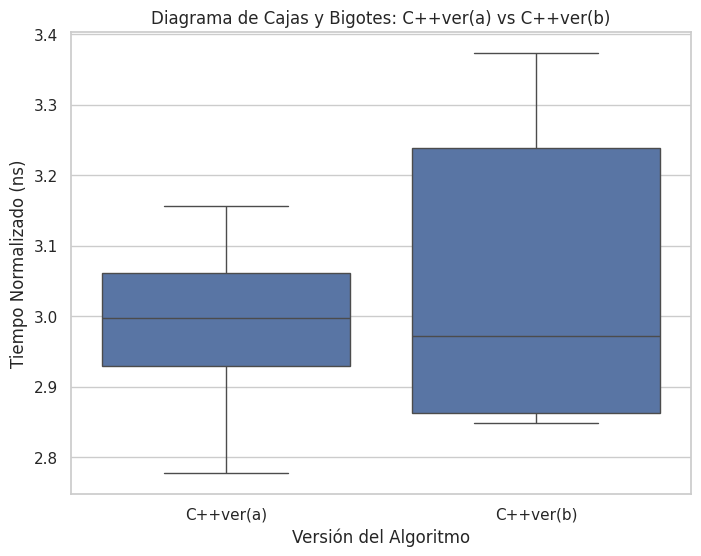

In [ ]:
# Filtrar solo las versiones ver(a) y ver(b)
df_ab = df[df["version"].isin(["C++ver(a)", "C++ver(b)"])]

# Crear el gráfico de cajas y bigotes
plt.figure(figsize=(8, 6))
sns.boxplot(x="version", y="Normalized_ns", data=df_ab)
plt.xlabel("Versión del Algoritmo")
plt.ylabel("Tiempo Normalizado (ns)")
plt.title("Diagrama de Cajas y Bigotes: C++ver(a) vs C++ver(b)")

# Mostrar el gráfico
plt.show()

**P7.** ¿Considera que los datos atípicos en éste aso afectaría la prueba de hipótesis?

**ANOVA par 1 ver(a) ver(b)**

Escriba las hipótesis para esta prueba:

$H_1$:

$H_0$:

**ANOVA para la comparación entre C++ver(a) y C++ver(b):**

Importante: Anque la prueba de Tukey ya respondió la pregunta sobre si hay diferencias significactivas entre la versión (a) y versión (b), vamos igual aplicar el ANOVA para estos dos grupos, aunque ya sabemos la respuesta.


In [ ]:
modelo_ab = ols('Normalized_ns ~ C(version)', data=df_ab).fit() # La fórmula 'Normalized_ns ~ C(version)' indica que se está evaluando el efecto de la variable 'version' sobre la variable 'Normalized_ns'.
# Calcular la tabla ANOVA
tabla_anova_ab = anova_lm(modelo_ab, typ=2) #anova_lm() para calcular la tabla ANOVA a partir del modelo ajustado. El argumento typ=2 especifica que se debe utilizar el tipo 2 (El orden de las variables en el modelo no afecta el cálculo) de suma de cuadrados.
# Mostrar la tabla ANOVA
print(tabla_anova_ab)
# Imprimir el valor p para C(version)
print("Valor p para C(version):", tabla_anova_ab.loc['C(version)', 'PR(>F)'])


              sum_sq    df         F    PR(>F)
C(version)  0.023500   1.0  0.818984  0.375282
Residual    0.631271  22.0       NaN       NaN
Valor p para C(version): 0.37528171972206514


**P8.** Interprete los resultados del ANOVA:




**Análisis de valores atípicos par de versions 1 Ver(a) Ver(b)**


In [ ]:
print("================= Análisis de valores atípicos =========================")

data_ver_a=df[df['version'].isin(['ver(a)'])]
datos = data_ver_a['Normalized_ns']  # Reemplaza con la columna de datos que deseas analizar
outliers = detectar_outliers_desviacion_estandar(datos,1)
print("Outliers detectados ver(b):", outliers)

data_ver_b=df[df['version'].isin(['ver(b)'])]
datos = data_ver_a['Normalized_ns']  # Reemplaza con la columna de datos que deseas analizar
outliers = detectar_outliers_desviacion_estandar(datos,1)
print("Outliers detectados ver(b):", outliers)

================= Análisis de valores atípicos =========================
Outliers detectados ver(b): []
Outliers detectados ver(b): []


**P9.** ¿Qué criterio utilizamos para identificar un dato dato atípico?


**P10.** Si se detectan, ¿Con qué valor reemplazamos un valor atípico?


Siga el mismo procedimiento de análisis que realizó con el par Ver(a) Ver(b) y apliquelo para el par ver(c)-ver(d) y par ver(e)-ver(f) de versiones.



**ANOVA de dos vías**

El **Análisis de Varianza de Dos Vías** (ANOVA de Dos Vías) es una técnica estadística utilizada para analizar el efecto que tiene dos factores simultáneamente sobre una variable de respuesta. En este caso, el objetivo es evaluar cómo influyen la versión del algoritmo y el tamaño de la matriz en el tiempo de ejecución normalizado.

En el análisis de ANOVA de una vía, se examinó el impacto de la versión del algoritmo como único factor. Sin embargo, en aplicaciones computacionales, el rendimiento de un algoritmo no depende únicamente del código implementado, sino también del tamaño de los datos que se procesan y cómo estos interactúan con la jerarquía de memoria del sistema.

Por esta razón, el ANOVA de Dos Vías nos permitirá responder las siguientes preguntas clave:

**1** ¿Las diferentes versiones del algoritmo presentan diferencias significativas en el tiempo de ejecución?

**2** ¿El tamaño de la matriz de datos afecta significativamente el rendimiento (tiempo normalizado) ?

**3** ¿Existe una interacción entre la versión del algoritmo y el tamaño de la matriz? Es decir, ¿el impacto de la versión del algoritmo en el rendimiento cambia dependiendo del tamaño de la matriz?

https://bookdown.org/dereksonderegger/571/6-two-way-anova.html


**Procedimiento**

**Determinación de los niveles del tamaño de la matriz**

Antes de realizar el análisis de ANOVA de Dos Vías, es fundamental definir cuántos niveles de tamaño de matriz se evaluarán y en qué rango deben estar.

**Preguntas a considerar:**

**1** ¿Cuántos niveles de tamaño de matriz se deben seleccionar?

**2** ¿Cuáles deberían ser esos valores?

**3** ¿En qué rango deben estar los tamaños de matriz para garantizar que reflejen diferencias significativas en el rendimiento?

Para responder estas preguntas, se debe considerar la jerarquía de memoria del sistema en el que se ejecutarán los experimentos.


**Jerarquía de Memoria y su impacto en el tamaño de la matriz**

¿Por qué es importante la jerarquía de memoria?

La arquitectura de memoria de un computador está compuesta por varios niveles de caché y RAM, cada uno con diferentes velocidades y tamaños. Cuando un programa accede a datos, la ubicación de estos datos en la memoria puede afectar drásticamente su rendimiento.

Para este análisis, se considerarán cinco niveles de tamaño de matriz, alineados con los diferentes niveles de la jerarquía de memoria.

Ejemplo de un sistema con la siguiente configuración:

  L1 Data Cache: 4 × 48 KB (8-way)

  L2 Cache: 4 × 1.25 MB (20-way)

  L3 Cache: 8 MB (8-way)

  RAM: Se seleccionará un tamaño que exceda la caché para evaluar el impacto en la memoria


Dado que la multiplicación de matrices involucra tres matrices (
A,B,C), el total de memoria requerida será:

Memoria_total=3xn^2x4 bytes

n es el tamaño de la matriz (se busca averiguar).
Cada elemento ocupa 4 bytes (simple precision floating-point).


Con los 6 ejecutables generados en la semana 2 (C:\lab_10X\Ejecutables), vamos a agregar el tamaño de la matriz de datos como un segundo factor.
Los niveles con los cuales vamos a trabajar son los siguientes:


**matriz de aleatorización**

En un experimento bien diseñado, es fundamental minimizar cualquier fuente de variabilidad que pueda afectar los resultados, aparte de los factores que se están estudiando. Uno de los aspectos clave que puede introducir sesgos en la medición del rendimiento es el orden de ejecución de los tratamientos experimentales.

La matriz de aleatorización es una herramienta utilizada para asignar de forma aleatoria el orden en que se ejecutan los tratamientos en el experimento. Este procedimiento garantiza que los factores externos no influyan sistemáticamente en los resultados, proporcionando así una evaluación más precisa y objetiva del impacto de los factores de estudio.

**Importancia de la Aleatorización**

  **Elimina el sesgo:**
  Asignar aleatoriamente el orden de ejecución ayuda a evitar que factores desconocidos o no controlados afecten los resultados. Por ejemplo, es común observar que la primera ejecución de una serie de repeticiones es más lenta debido a factores como la carga inicial del sistema o efectos de caché.


**Asegurar la validez interna del experimento:**
  La aleatorización permite garantizar que cualquier diferencia observada en los resultados se deba exclusivamente a los factores bajo estudio y no a efectos colaterales no controlados, como el orden de ejecución o variaciones del entorno de ejecución.


**Implementación de la Matriz de Aleatorización**

El siguiente script genera una lista aleatorizada de las 48 ejecuciones combinando los dos factores de estudio:

    Factor 1: Versión del algoritmo.

    Factor 2: Tamaño de la matriz.

Este script también genera la lista de comandos en el formato adecuado para ser utilizado en PowerShell al ejecutar los experimentos con los ejecutables ProductMatrix_X64_verX.exe:

In [ ]:
import random

# Lista de ejecutables
versions = [
    ".\ProductMatrix_cpp_f_x64_verA.exe",
    ".\ProductMatrix_cpp_f_x64_verB.exe",
    ".\ProductMatrix_cpp_f_x64_verC.exe",
    ".\ProductMatrix_cpp_f_x64_verD.exe",
    ".\ProductMatrix_cpp_f_x64_verE.exe",
    ".\ProductMatrix_cpp_f_x64_verF.exe"
]

# Lista de tamaños de matriz
matrix_sizes = [ 128,	181,	467,	661,	591,	836,	1182] # indique los niveles calculados
samples =      [10  , 10, 10, 10, 10, 10, 10, 10  ]

# Generar combinaciones
combinations = [
    (version, size, sample)
    for version in versions
    for size, sample in zip(matrix_sizes, samples)
]
# Aleatorizar la lista de combinaciones
random.shuffle(combinations)

# Mostrar combinaciones aleatorizadas
for combination in combinations:
    print(combination[0], combination[1],  combination[2])


.\ProductMatrix_cpp_f_x64_verE.exe 591 10
.\ProductMatrix_cpp_f_x64_verA.exe 1182 10
.\ProductMatrix_cpp_f_x64_verB.exe 836 10
.\ProductMatrix_cpp_f_x64_verC.exe 591 10
.\ProductMatrix_cpp_f_x64_verC.exe 661 10
.\ProductMatrix_cpp_f_x64_verA.exe 467 10
.\ProductMatrix_cpp_f_x64_verD.exe 1182 10
.\ProductMatrix_cpp_f_x64_verE.exe 661 10
.\ProductMatrix_cpp_f_x64_verE.exe 467 10
.\ProductMatrix_cpp_f_x64_verB.exe 181 10
.\ProductMatrix_cpp_f_x64_verF.exe 1182 10
.\ProductMatrix_cpp_f_x64_verB.exe 591 10
.\ProductMatrix_cpp_f_x64_verB.exe 1182 10
.\ProductMatrix_cpp_f_x64_verC.exe 128 10
.\ProductMatrix_cpp_f_x64_verC.exe 181 10
.\ProductMatrix_cpp_f_x64_verA.exe 591 10
.\ProductMatrix_cpp_f_x64_verE.exe 128 10
.\ProductMatrix_cpp_f_x64_verA.exe 836 10
.\ProductMatrix_cpp_f_x64_verA.exe 181 10
.\ProductMatrix_cpp_f_x64_verD.exe 836 10
.\ProductMatrix_cpp_f_x64_verF.exe 128 10
.\ProductMatrix_cpp_f_x64_verD.exe 467 10
.\ProductMatrix_cpp_f_x64_verF.exe 181 10
.\ProductMatrix_cpp_f_x64_verE

**Ejecución en PowerShell ISE**
Para ejecutar los experimentos de forma organizada y registrar los datos de manera adecuada, siga los siguientes pasos en PowerShell ISE:

**Acceder a la Carpeta de Ejecutables**

Abrir PowerShell ISE:

Presione Win + R, escriba powershell_ise, y presione Enter.
Navegar a la carpeta de ejecutables:

Utilice el siguiente comando para moverse a la carpeta donde están los ejecutables del experimento:

    cd D:\lab101\ejecutables

**Copiar la lista de comandos generados en el paso anterior.**

copie y pegue en el en la zona de script la secuencia de comandos generada en el paso anterior, guarde como **TwoFactors_Ver_vs_N_lab101_LHW_XX**

Si en la carpeta de ejecutables existe un archivo de reporte de datos .txt, borrelo o cambie el nombre.

**Ejecutar el script en PowerShell:**
En PowerShell ISE, haga clic en el botón de Ejecutar (Run)


**Importar los datos a Excel:**

Una vez termine las **42** ejecuciones, importe los datos el archivo Excel, en una hoja con nombre **"TwoFactors"**, indique los nombres de las columnas:

**version    typeData      ISA    	 #sample 	n      	 time_s 	Normalized_ns**

**Tabla ANOVA dos vías**




In [ ]:
df2f = pd.read_excel("Lab semana 2 Part 2_Product Matrix_Datos.xlsx","TwoFactors")
#df2f= df2f.drop(columns=['typeData', 'ISA'])
df2f = df2f.rename(columns={"Normalized(ns)":"Normalized_ns"})
df2f = df2f.rename(columns={"ver":"version"})
#df2f['version'] =df2f.Categorical(df2f['version'])
df2f['version'] = df2f['version'].str.strip()  # Eliminar espacios en blanco al inicio y al final de los valores de la columna 'version'
df2f.info()
print(df2f.head())
modeloTwoWay = ols('Q("Normalized_ns") ~ C(version) + C(n) + C(version) * C(n)', alpha=0.05, data=df2f).fit()
# Mostrar los resultados
print("===========          TABLA ANOVA Two ways         ================")
tabla_anova = anova_lm(modeloTwoWay , typ=2) # Type 2 ANOVA DataFrame
print(tabla_anova)
print(" ")
print("Valor p para C(version):", tabla_anova.loc['C(version)', 'PR(>F)'])
print("Valor p para C(n):", tabla_anova.loc['C(n)', 'PR(>F)'])
print("Valor p para la interacción:", tabla_anova.loc['C(version):C(n)', 'PR(>F)'])
print("alpha: 0.05")
print("================= -------------- =========================")
print("")



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539 entries, 0 to 538
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   version        539 non-null    object 
 1   typeData       539 non-null    object 
 2   ISA            539 non-null    object 
 3   #sample        539 non-null    int64  
 4   n              539 non-null    int64  
 5   time_s         539 non-null    float64
 6   Normalized_ns  539 non-null    float64
dtypes: float64(2), int64(2), object(3)
memory usage: 29.6+ KB
     version typeData  ISA  #sample    n  time_s  Normalized_ns
0  C++ver(b)    float  x64        0  661   0.676         2.3407
1  C++ver(b)    float  x64        1  661   0.669         2.3164
2  C++ver(b)    float  x64        2  661   0.684         2.3684
3  C++ver(b)    float  x64        3  661   0.676         2.3407
4  C++ver(b)    float  x64        4  661   0.649         2.2472
===========          TABLA ANOVA Two ways         ===

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['alpha']
  warnings.warn(msg, ValueWarning)


**P11.** Escriba su interpretación respecto a las conclusiones y calidad del experimento incluyendo los siguientes parámetros:

• Valor p

• SCT (Suma Total de Cuadrados)

• SCM (Suma de Cuadrados del Modelo)

• SCE (Suma de Cuadrados del Error)

**Gráfico de Interacción**

El gráfico de interacción es una herramienta visual clave para analizar cómo dos factores influyen conjuntamente en una variable de respuesta. En este caso, se representa el tiempo de ejecución normalizado en función del tamaño de la matriz, diferenciando cada versión del algoritmo mediante colores.

**¿Por qué es importante este gráfico?**

**Detecta efectos principales y su impacto en el rendimiento:**
Permite observar cómo el tamaño de la matriz (𝑛) influye en el tiempo de ejecución.
Muestra si las versiones del algoritmo tienen diferencias significativas en su rendimiento.

**Identifica interacciones entre los factores:**
Si las líneas de diferentes versiones no son paralelas, significa que el efecto de la versión del algoritmo varía según el tamaño de la matriz.
Esto indicaría que ciertas versiones del algoritmo se benefician más o menos según el tamaño de los datos.




<ipython-input-50-d59dcf07d20f>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.catplot(x='n', y='Normalized_ns', hue='version', kind='point', data=df2f, ci=None)


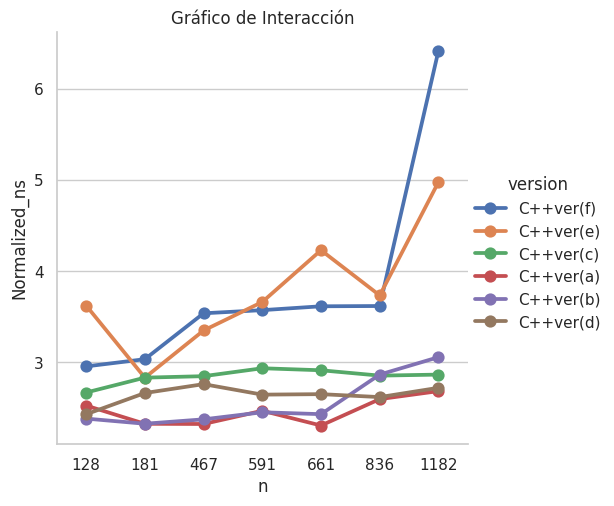

In [ ]:
# Creamos la gráfica de interacciones
sns.catplot(x='n', y='Normalized_ns', hue='version', kind='point', data=df2f, ci=None)
plt.title('Gráfico de Interacción')
plt.show()